## Gas Sensor Array Drift - Modeling

In [3]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

In [4]:
seed = 10

### Leitura dos Dados

In [5]:
dataset = pd.read_csv('../Dataset/dataset_pca.csv')

In [6]:
print(dataset.shape)
dataset.head()

(13910, 25)


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,target
0,-2.339565,0.198422,-0.173254,0.216613,0.267055,-0.025103,0.052416,0.050608,0.013126,0.033547,...,-0.007222,-0.006154,0.009660,0.003787,0.020207,0.034466,-0.010471,-0.012667,0.009506,1.0
1,-2.108847,0.266302,-0.109280,0.187270,0.257059,-0.014747,0.098163,0.050763,0.001345,0.027209,...,-0.017720,-0.001472,0.011223,-0.006269,0.032545,0.036374,-0.021074,-0.013904,0.004126,1.0
2,-1.806437,0.367635,-0.018661,0.181458,0.279032,0.000210,0.154078,0.055977,-0.009243,0.007621,...,-0.006342,-0.015004,0.009204,-0.000443,0.034913,0.031931,-0.020171,-0.016194,0.010860,1.0
3,-1.654477,0.411155,-0.005173,0.081328,0.289931,0.096692,0.115238,0.016243,-0.017247,0.052043,...,-0.022185,0.038554,-0.010184,0.050581,0.020085,0.021108,0.025204,-0.037345,0.014856,1.0
4,-1.404309,0.475124,0.112300,0.192767,0.322900,0.032027,0.222424,0.070189,-0.015679,-0.016262,...,0.003993,-0.030851,0.005612,0.011120,0.035992,0.034510,-0.011359,-0.021883,0.011947,1.0


## Data Separation

In [7]:
X = dataset.drop('target', axis=1)
y = dataset.loc[:,'target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

## Classification

In [15]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=20)

### k-NN

#### Selection of parameters n_neighbors and metric


In [16]:
results = []
for k in range(1, 11):
    for metric in ['euclidean', 'manhattan', 'chebyshev']:
        params = {'n_neighbors': k, 'metric': metric}
        
        clf_knn = KNeighborsClassifier(**params)
        
        scores = cross_val_score(clf_knn, X_train, y_train, cv=kfold)
        scores_mean = scores.mean()
        scores_std = scores.std()
        
        results.append((params, scores_mean, scores_std))
        
        print('Acuracia - KNN: k = %2d, metric = %s, scores: %0.3f' % (k, metric, scores_mean))

Acuracia - KNN: k =  1, metric = euclidean, scores: 0.995
Acuracia - KNN: k =  1, metric = manhattan, scores: 0.996
Acuracia - KNN: k =  1, metric = chebyshev, scores: 0.994
Acuracia - KNN: k =  2, metric = euclidean, scores: 0.994
Acuracia - KNN: k =  2, metric = manhattan, scores: 0.995
Acuracia - KNN: k =  2, metric = chebyshev, scores: 0.993
Acuracia - KNN: k =  3, metric = euclidean, scores: 0.994
Acuracia - KNN: k =  3, metric = manhattan, scores: 0.995
Acuracia - KNN: k =  3, metric = chebyshev, scores: 0.992
Acuracia - KNN: k =  4, metric = euclidean, scores: 0.993
Acuracia - KNN: k =  4, metric = manhattan, scores: 0.994
Acuracia - KNN: k =  4, metric = chebyshev, scores: 0.991
Acuracia - KNN: k =  5, metric = euclidean, scores: 0.992
Acuracia - KNN: k =  5, metric = manhattan, scores: 0.994
Acuracia - KNN: k =  5, metric = chebyshev, scores: 0.989
Acuracia - KNN: k =  6, metric = euclidean, scores: 0.991
Acuracia - KNN: k =  6, metric = manhattan, scores: 0.993
Acuracia - KNN

In [17]:
results = np.array(results)
idx_best_result = results[:, 1].argmax()
results[idx_best_result]

array([{'n_neighbors': 1, 'metric': 'manhattan'}, 0.99595606533641,
       0.0016200590544065815], dtype=object)

In [18]:
df_results = pd.DataFrame(results)
df_params = df_results[0].apply(lambda x: pd.Series(x))
df_results = pd.concat([df_results.drop(0, axis=1), df_params], axis=1)
df_results.columns = ['score_mean', 'score_std', 'k', 'metric']
df_results.head()

,score_mean,score_std,k,metric
0,0.995237,0.001209,1,euclidean
1,0.995956,0.00162,1,manhattan
2,0.993799,0.001236,1,chebyshev
3,0.994428,0.002001,2,euclidean
4,0.994878,0.0018,2,manhattan


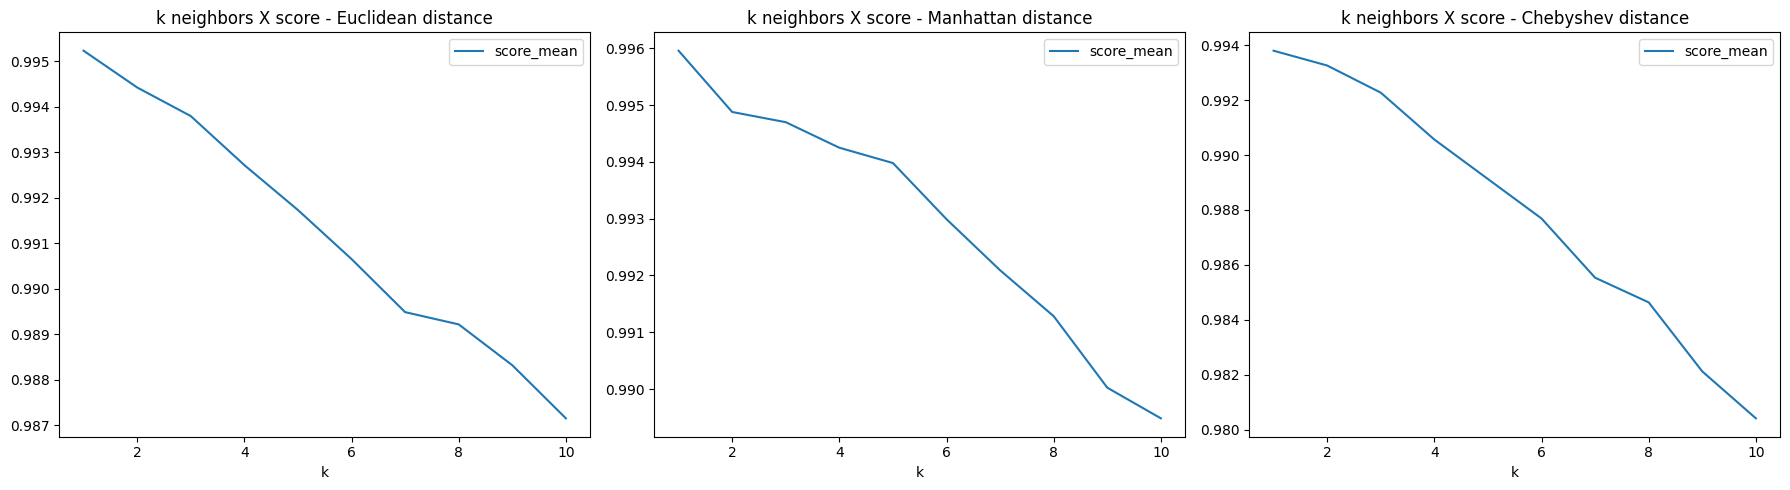

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

df_results[df_results['metric'] == 'euclidean'].plot(x='k', y='score_mean', ax=axs[0], title='k neighbors X score - Euclidean distance')
df_results[df_results['metric'] == 'manhattan'].plot(x='k', y='score_mean', ax=axs[1], title='k neighbors X score - Manhattan distance')
df_results[df_results['metric'] == 'chebyshev'].plot(x='k', y='score_mean', ax=axs[2], title='k neighbors X score - Chebyshev distance')

plt.tight_layout()
plt.show()

For all three distance metrics (Euclidean, Manhattan, and Chebyshev) used in the experiments for hyperparameter tuning, the model's performance decreased as the value of k (number of neighbors) increased. The best value found in the experiments was k=1 and the Manhattan distance. It is likely that the value 1 was the best due to the nature of the problem and the data, where there are very similar measurements, so the greatest similarity between the attributes should be from the same gas.

#### Selection of the parameter weights


In [20]:
results_2 = []
for k in range(1, 4):
    for weight in ['uniform', 'distance']:
        params = {'n_neighbors': k, 'weights': weight}
        
        clf_knn = KNeighborsClassifier(**params, metric='manhattan')
        
        scores = cross_val_score(clf_knn, X_train, y_train, cv=kfold)
        scores_mean = scores.mean()
        scores_std = scores.std()
        
        results_2.append((params, scores_mean, scores_std))
        
        print('Acuracia - KNN: k = %2d, metric = %s, scores: %0.3f' % (k, weight, scores_mean))

Acuracia - KNN: k =  1, metric = uniform, scores: 0.996
Acuracia - KNN: k =  1, metric = distance, scores: 0.996
Acuracia - KNN: k =  2, metric = uniform, scores: 0.995
Acuracia - KNN: k =  2, metric = distance, scores: 0.996
Acuracia - KNN: k =  3, metric = uniform, scores: 0.995
Acuracia - KNN: k =  3, metric = distance, scores: 0.996


In [21]:
results_2 = np.array(results_2)
idx_best_result = results_2[:, 1].argmax()
results_2[idx_best_result]

array([{'n_neighbors': 1, 'weights': 'uniform'}, 0.99595606533641,
       0.0016200590544065815], dtype=object)

In [22]:
df_results = pd.DataFrame(results_2)
df_params = df_results[0].apply(lambda x: pd.Series(x))
df_results = pd.concat([df_results.drop(0, axis=1), df_params], axis=1)
df_results.columns = ['score_mean', 'score_std', 'k', 'weight']
df_results.sort_values('score_mean', ascending=False).head()

,score_mean,score_std,k,weight
0,0.995956,0.00162,1,uniform
1,0.995956,0.00162,1,distance
3,0.995956,0.00162,2,distance
5,0.995597,0.00136,3,distance
2,0.994878,0.0018,2,uniform


After finding that lower k values yielded better results, experiments were conducted to determine the optimal value for the weights parameter. The two options investigated for this parameter were uniform weighting for instances and weighted calculation, assigning higher weights to closer instances. The best result was still for k=1, but now k=2 with weighted weights appeared with the same score. Even so, the value of k remains very small, and using weighted weights in this case will not have a significant impact

### Decistion Tree

#### Selection of parameters criterion, max_depth, and min_samples_split

In [23]:
criterion_list = ['gini', 'entropy']
max_depth_list = [None, 3, 5, 9, 15, 25]
min_samples_split_list = [2, 3, 5, 7, 10]

In [24]:
results = []
for criterion in criterion_list:
    for max_depth in max_depth_list:
        for min_samples_split in min_samples_split_list: 
            params = {'criterion': criterion, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
        
            clf_df = DecisionTreeClassifier(**params)

            scores = cross_val_score(clf_df, X_train, y_train, cv=kfold)
            scores_mean = scores.mean()
            scores_std = scores.std()

            results.append((params, scores_mean, scores_std))

            print('Acuracia - DF: criterion = %s max_depth = %s, min_samples_split = %s scores: %0.3f' % (criterion, str(max_depth), min_samples_split, scores_mean))

Acuracia - DF: criterion = gini max_depth = None, min_samples_split = 2 scores: 0.977
Acuracia - DF: criterion = gini max_depth = None, min_samples_split = 3 scores: 0.977
Acuracia - DF: criterion = gini max_depth = None, min_samples_split = 5 scores: 0.975
Acuracia - DF: criterion = gini max_depth = None, min_samples_split = 7 scores: 0.973
Acuracia - DF: criterion = gini max_depth = None, min_samples_split = 10 scores: 0.973
Acuracia - DF: criterion = gini max_depth = 3, min_samples_split = 2 scores: 0.571
Acuracia - DF: criterion = gini max_depth = 3, min_samples_split = 3 scores: 0.571
Acuracia - DF: criterion = gini max_depth = 3, min_samples_split = 5 scores: 0.571
Acuracia - DF: criterion = gini max_depth = 3, min_samples_split = 7 scores: 0.571
Acuracia - DF: criterion = gini max_depth = 3, min_samples_split = 10 scores: 0.571
Acuracia - DF: criterion = gini max_depth = 5, min_samples_split = 2 scores: 0.784
Acuracia - DF: criterion = gini max_depth = 5, min_samples_split = 3 s

In [52]:
results = np.array(results)
idx_best_result = results[:, 1].argmax()
results[idx_best_result]

array([{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2},
       0.9782358934125479, 0.004458201358750323], dtype=object)

In [53]:
df_results = pd.DataFrame(results)
df_params = df_results[0].apply(lambda x: pd.Series(x))
df_results = pd.concat([df_results.drop(0, axis=1), df_params], axis=1)
df_results.columns = ['score_mean', 'score_std', 'criterion', 'max_depth', 'min_samples_split']
df_results.head()

,score_mean,score_std,criterion,max_depth,min_samples_split
0,0.978236,0.0044582,gini,NaN,2
1,0.975839,0.00565631,gini,NaN,3
2,0.976031,0.00626012,gini,NaN,5
3,0.974018,0.0053706,gini,NaN,7
4,0.974593,0.00539892,gini,NaN,10


In [55]:
df_results.sort_values('score_mean', ascending=False).head(10)

,score_mean,score_std,criterion,max_depth,min_samples_split
0,0.978236,0.0044582,gini,NaN,2
25,0.977279,0.00526324,gini,25.0,2
26,0.977277,0.00420608,gini,25.0,3
51,0.976514,0.00475808,entropy,15.0,3
32,0.97642,0.00662253,entropy,NaN,5
57,0.976229,0.0054753,entropy,25.0,5
31,0.976132,0.00594245,entropy,NaN,3
55,0.976034,0.00606668,entropy,25.0,2
2,0.976031,0.00626012,gini,NaN,5
53,0.975939,0.00525604,entropy,15.0,7


Analysis of the Top 10 Results for Hyperparameter Tuning of Decision Trees

Key Findings

Tree Depth: The depth of the decision tree should be reasonably large, especially compared to the investigated ranges. In addition to high values like 15 and 25, the null value (NaN) indicates that the tree will not have a predetermined size, allowing it to grow and then be pruned. This value for the max_depth parameter is present in a significant portion of the top results, including the best one.

Criterion: The parameter that determines the attribute quality measure used by the tree performed best with Gini Impurity, occupying the top three positions. Meanwhile, Entropy (the parameter indicating the Information Gain quality criterion) appeared in 60% of the top 10 results.

Minimum Samples per Split: The minimum number of examples required to split a node was low (min_samples_split). There was only one occurrence of a relatively high value, and it occupied the 10th position.

### Random Forest

#### Selection of the parameter n_estimators 

In [20]:
results = []
for n_estimators in range(10,401,20):
    clf_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=10, n_jobs=-1)
    
    scores = cross_val_score(clf_rf, X_train, y_train, cv=kfold)
    scores_mean = scores.mean()
    scores_std = scores.std()
    
    results.append(({'n_estimators': n_estimators}, scores_mean, scores_std))

    print('Acuracia - RF: n_estimators = %2d, scores: %0.3f' % (n_estimators, scores_mean))

Acuracia - RF: n_estimators = 10, scores: 0.993
Acuracia - RF: n_estimators = 30, scores: 0.994
Acuracia - RF: n_estimators = 50, scores: 0.994
Acuracia - RF: n_estimators = 70, scores: 0.994
Acuracia - RF: n_estimators = 90, scores: 0.994
Acuracia - RF: n_estimators = 110, scores: 0.994
Acuracia - RF: n_estimators = 130, scores: 0.994
Acuracia - RF: n_estimators = 150, scores: 0.994
Acuracia - RF: n_estimators = 170, scores: 0.994
Acuracia - RF: n_estimators = 190, scores: 0.994
Acuracia - RF: n_estimators = 210, scores: 0.994
Acuracia - RF: n_estimators = 230, scores: 0.994
Acuracia - RF: n_estimators = 250, scores: 0.994
Acuracia - RF: n_estimators = 270, scores: 0.994
Acuracia - RF: n_estimators = 290, scores: 0.994
Acuracia - RF: n_estimators = 310, scores: 0.994
Acuracia - RF: n_estimators = 330, scores: 0.994
Acuracia - RF: n_estimators = 350, scores: 0.994
Acuracia - RF: n_estimators = 370, scores: 0.994
Acuracia - RF: n_estimators = 390, scores: 0.994


In [21]:
results = np.array(results)
idx_best_result = results[:, 1].argmax()
results[idx_best_result]

array([{'n_estimators': 110}, 0.9944402058863577, 0.002599884725692586],
      dtype=object)

In [22]:
df_results = pd.DataFrame(results)
df_params = df_results[0].apply(lambda x: pd.Series(x))
df_results = pd.concat([df_results.drop(0, axis=1), df_params], axis=1)
df_results.columns = ['score_mean', 'score_std', 'n_estimators']
df_results.head()

,score_mean,score_std,n_estimators
0,0.992524,0.0028659,10
1,0.993674,0.00318326,30
2,0.993962,0.00296832,50
3,0.993961,0.00281137,70
4,0.993961,0.00267924,90


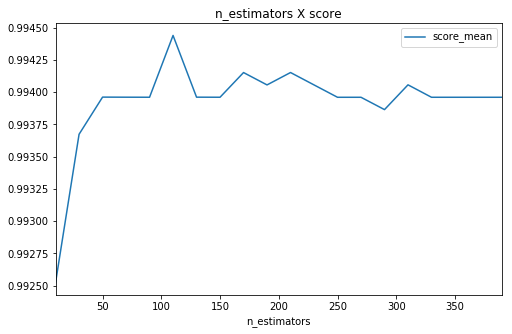

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))

df_results.plot(x='n_estimators', y='score_mean', ax=ax, title='n_estimators X score')
plt.show()

The number of estimators (n_estimators) is the main parameter of the Random Forest classifier. It defines the number of trees that will be used. The result found presents stability when the value exceeds 50 estimators (or trees), but shows an increase when 110 trees are used, which is the best value found.

### MLP

In [25]:
results = []

activ = ['logistic', 'tanh', 'relu']
solv = ['lbfgs', 'sgd', 'adam']

for sol in solv:
    
    for act in activ:

        for i in range(20,100,10):
        
            hidden_layer_sizes_mlp1 = (i,)
            hidden_layer_sizes_mlp2 = (i-5,i-10)
            hidden_layer_sizes_mlp3 = (i-5,i-5,i-10)
            
            mlp1 = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes_mlp1, solver=sol, activation=act,
                                 max_iter=2000, random_state=10)
            mlp2 = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes_mlp2, solver=sol, activation=act,
                                 max_iter=2000, random_state=10)
            mlp3 = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes_mlp3, solver=sol, activation=act,
                                 max_iter=2000, random_state=10)
    
            scores_mlp1 = cross_val_score(mlp1, X_train, y_train, cv=kfold)
            scores_mean_mlp1 = scores_mlp1.mean()
            scores_std_mlp1 = scores_mlp1.std()

            results.append(({'solver': sol, 'activation': act, 'hidden_layer_sizes': hidden_layer_sizes_mlp1}, scores_mean_mlp1, scores_std_mlp1))
            print("Acuracia - MLP", hidden_layer_sizes_mlp1, sol, act, scores_mean_mlp1)
            
            scores_mlp2 = cross_val_score(mlp2, X_train, y_train, cv=kfold)
            scores_mean_mlp2 = scores_mlp2.mean()
            scores_std_mlp2 = scores_mlp2.std()
            
            results.append(({'solver': sol, 'activation': act, 'hidden_layer_sizes': hidden_layer_sizes_mlp2}, scores_mean_mlp2, scores_std_mlp2))
            print("Acuracia - MLP", hidden_layer_sizes_mlp2, sol, act, scores_mean_mlp2)
            
            scores_mlp3 = cross_val_score(mlp3, X_train, y_train, cv=kfold)
            scores_mean_mlp3 = scores_mlp3.mean()
            scores_std_mlp3 = scores_mlp3.std()
            
            results.append(({'solver': sol, 'activation': act, 'hidden_layer_sizes': hidden_layer_sizes_mlp3}, scores_mean_mlp3, scores_std_mlp3))
            print("Acuracia - MLP", hidden_layer_sizes_mlp3, sol, act, scores_mean_mlp3)

Acuracia - MLP (20,) lbfgs logistic 0.9935791429052125
Acuracia - MLP (15, 10) lbfgs logistic 0.9899326747622716
Acuracia - MLP (15, 15, 10) lbfgs logistic 0.991850409614532
Acuracia - MLP (30,) lbfgs logistic 0.9933838981918056
Acuracia - MLP (25, 20) lbfgs logistic 0.9934820722752056
Acuracia - MLP (25, 25, 20) lbfgs logistic 0.9920443708956826
Acuracia - MLP (40,) lbfgs logistic 0.9948217848327318
Acuracia - MLP (35, 30) lbfgs logistic 0.9921387787816205
Acuracia - MLP (35, 35, 30) lbfgs logistic 0.9934795909196584
Acuracia - MLP (50,) lbfgs logistic 0.9936721742925787
Acuracia - MLP (45, 40) lbfgs logistic 0.9936723537411094
Acuracia - MLP (45, 45, 40) lbfgs logistic 0.9925232968638443
Acuracia - MLP (60,) lbfgs logistic 0.9940563269643429
Acuracia - MLP (55, 50) lbfgs logistic 0.9937694278914581
Acuracia - MLP (55, 55, 50) lbfgs logistic 0.9939614583106231
Acuracia - MLP (70,) lbfgs logistic 0.9941531212020609
Acuracia - MLP (65, 60) lbfgs logistic 0.9928078072954565
Acuracia - ML

C:\Users\Milton\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Milton\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Milton\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Milton\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

Acuracia - MLP (15, 10) sgd logistic 0.9526408197699819
Acuracia - MLP (15, 15, 10) sgd logistic 0.21740812175077023
Acuracia - MLP (30,) sgd logistic 0.9470820450134637


C:\Users\Milton\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Milton\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Milton\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Milton\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, 

Acuracia - MLP (25, 20) sgd logistic 0.9649130577914145
Acuracia - MLP (25, 25, 20) sgd logistic 0.21740812175077023
Acuracia - MLP (40,) sgd logistic 0.94851965984007
Acuracia - MLP (35, 30) sgd logistic 0.962806691368524
Acuracia - MLP (35, 35, 30) sgd logistic 0.21740812175077023
Acuracia - MLP (50,) sgd logistic 0.9483282712226379
Acuracia - MLP (45, 40) sgd logistic 0.958874338583368
Acuracia - MLP (45, 45, 40) sgd logistic 0.21740812175077023
Acuracia - MLP (60,) sgd logistic 0.9480417419639349
Acuracia - MLP (55, 50) sgd logistic 0.9666392175355046
Acuracia - MLP (55, 55, 50) sgd logistic 0.21740812175077023
Acuracia - MLP (70,) sgd logistic 0.9475620781311316
Acuracia - MLP (65, 60) sgd logistic 0.9637624347529832
Acuracia - MLP (65, 65, 60) sgd logistic 0.21740812175077023
Acuracia - MLP (80,) sgd logistic 0.9498632286678182
Acuracia - MLP (75, 70) sgd logistic 0.9610792434379386
Acuracia - MLP (75, 75, 70) sgd logistic 0.21740812175077023
Acuracia - MLP (90,) sgd logistic 0.9

In [26]:
results_ = np.array(results)
idx_best_result = results_[:, 1].argmax()
results_[idx_best_result]

array([{'solver': ['lbfgs', 'sgd', 'adam'], 'activation': ['logistic', 'tanh', 'relu'], 'hidden_layer_sizes': (55, 55, 50)},
       0.9956860628111752, 0.0013732259575810635], dtype=object)

In [57]:
df_results = pd.DataFrame(results_)
df_params = df_results[0].apply(lambda x: pd.Series(x))
df_results = pd.concat([df_results.drop(0, axis=1), df_params], axis=1)
df_results.columns = ['score_mean', 'score_std', 'solver', 'activation', 'hidden_layer_sizes']
df_results.head()

,score_mean,score_std,activation,hidden_layer_sizes,solver
0,0.993579,0.0023829,logistic,"(20,)",lbfgs
1,0.989933,0.00419221,logistic,"(15, 10)",lbfgs
2,0.99185,0.00321953,logistic,"(15, 15, 10)",lbfgs
3,0.993384,0.00241175,logistic,"(30,)",lbfgs
4,0.993482,0.00217271,logistic,"(25, 20)",lbfgs


In [59]:
df_results.sort_values('score_mean', ascending=False)

,score_mean,score_std,activation,hidden_layer_sizes,solver
38,0.995686,0.00137323,tanh,"(55, 55, 50)",lbfgs
206,0.995303,0.00240569,relu,"(55, 55, 50)",adam
214,0.995302,0.00224798,relu,"(85, 80)",adam
202,0.995302,0.00163155,relu,"(45, 40)",adam
215,0.995207,0.00176901,relu,"(85, 85, 80)",adam
185,0.995017,0.00185475,tanh,"(65, 65, 60)",adam
208,0.995016,0.0020896,relu,"(65, 60)",adam
197,0.995015,0.00263786,relu,"(25, 25, 20)",adam
191,0.99492,0.00176713,tanh,"(85, 85, 80)",adam
199,0.994919,0.00231249,relu,"(35, 30)",adam


### Ensemble de MLP 

In [20]:
mlp = MLPClassifier(hidden_layer_sizes=(55, 55, 50), activation='tanh', solver='lbfgs', max_iter=2000, random_state=10)

# clf = VotingClassifier(estimators)
scores = cross_val_score(mlp, X_train, y_train, cv=kfold, n_jobs=-1)
scores_mean = scores.mean()
scores_std = scores.std()
print('Score: ', scores_mean)
print('std: ', scores_std)

Score:  0.9957814812564161
std:  0.0018315187535415073


### Heterogeneous Ensemble

In [10]:
estimators = [
    ('MLP', MLPClassifier(hidden_layer_sizes=(55, 55, 50), activation='tanh', solver='lbfgs', max_iter=2000, random_state=10)),
    ('KNN', KNeighborsClassifier(n_neighbors=1)),
    ('RF', RandomForestClassifier(n_estimators=110, random_state=10, n_jobs=-1)),
    ('DF', DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, random_state=10))
]

clf = VotingClassifier(estimators)
scores = cross_val_score(clf, X_train, y_train, cv=kfold, n_jobs=-1)
scores_mean = scores.mean()
scores_std = scores.std()
print('Score: ', scores_mean)
print('std: ', scores_std)

Score:  0.9961659090875881
std:  0.002100041415767633


In [18]:
clf = VotingClassifier(estimators)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print('Accurancy: ', accuracy_score(y_test, pred))

print(classification_report(y_true=y_test, y_pred=pred, digits=3))

Acurácia:  0.9953996549741231
              precision    recall  f1-score   support

         1.0      0.989     0.998     0.994       653
         2.0      0.997     0.993     0.995       733
         3.0      0.995     0.995     0.995       401
         4.0      0.996     0.998     0.997       504
         5.0      0.996     0.995     0.995       741
         6.0      1.000     0.993     0.997       446

   micro avg      0.995     0.995     0.995      3478
   macro avg      0.996     0.995     0.996      3478
weighted avg      0.995     0.995     0.995      3478

